# Running spike sorting on Neuropixel probes
This document covers how to run spike sorting. If you are running this for the first time, please follow the installation instructions below. Note, during installation you will create a new conda environment, kilosort, which must be used to run this notebook.

## Installation
Several pieces of software need to be installed before you can begin.
1. Create a conda environment for Kilosort4 by following the instructions on its [github page](https://github.com/MouseLand/Kilosort). Once the environment is created, we will add support for Jupyter notebooks and Matplotlib. To do this:
    1. In the anaconda terminal, enter the kilosort environment by typing `conda activate kilosort`.
    2. Install Jupyter notebooks by calling `pip install notebook`.
    3. Install Matplotlib by calling `python -m pip install matplotlib`.
2. Go the the [SpikeGLX site](https://billkarsh.github.io/SpikeGLX/) and download CatGT. For a detailed help of the processing options it offers, [see here](https://billkarsh.github.io/SpikeGLX/help/syncEdges/Sync_edges/#catgt-event-extraction). To better understand how it works, you can read the explanation [here](https://billkarsh.github.io/SpikeGLX/help/catgt_tshift/catgt_tshift/)
3. Once CatGT is downloaded, make it callable from the command line. The instructions for doing this on Windows are:
    1. Extract the CatGT-win folder and move it to the *C:\Program Files* directory.
    2. Type 'environment variables' into the search box in the Windows task bar and click the option 'Edit the system environment variables'.
    3. Click the 'Environment Variables...' button at the bottom of the window that pops up.
    4. Under the panel heading 'System variables', click on the line whose Variable name is 'Path' (the line should turn gray), and then press the 'Edit...' button.
    5. In the window that pops up, click the 'New' button. Enter the directory where CatGT was placed (*C:\Program Files\CatGT-win*).
    6. Do the same as steps 4-5 under the panel heading 'User variables for {user id here}'.
    7. Verify CatGT works by opening a terminal (type 'Command Prompt' into the Windows search bar) and entering 'CatGT'. If the environment variable was successfully modified after pressing enter the terminal should return a new command line and in the directory you called CatGT a log file will be created named *CatGT.log* that lists the configuration settings for CatGT.
4. Download *SGLXMetaToCoords.py* from its [github page](https://github.com/jenniferColonell/SGLXMetaToCoords/blob/main/SGLXMetaToCoords.py). Place it on the drive where you intend to place the files for sorting.
5. Download *SpikeGLX_Datafile_Tools* from its [github page](https://github.com/jenniferColonell/SpikeGLX_Datafile_Tools). Place the folder *DemoReadSGLXData* found in the *Python* directory on the drive where you intend to place the files for sorting. For a demonstration of how to use the functions contained in *readSGLX.py* check out this Jupyter notebook for [analog signals](https://github.com/jenniferColonell/SpikeGLX_Datafile_Tools/blob/main/Python/read_SGLX_analog.ipynb) or this one for [digital signals](https://github.com/jenniferColonell/SpikeGLX_Datafile_Tools/blob/main/Python/read_SGLX_digital.ipynb).
6. Make sure this notebook is placed on your spike sorting drive. You can save a new version of it each time you want to 


## Processing spike data
To run this code, call this notebook from the kilosort conda environment that you created above.

### Common settings
Note that on windows machines I use two slashes ('\\\\') instead of just one ('\\') to separate directories.

In [1]:
# need library to save as json
import os
import re
import subprocess
from pathlib import Path
import numpy as np
from kilosort.io import save_probe
from kilosort.parameters import DEFAULT_SETTINGS
from kilosort.run_kilosort import run_kilosort
import SGLXMetaToCoords as sglx

# set your data directory here, should contain the .ap.bin and .ap.meta files
file_dir = Path('D:\\SortingTest\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0\\')

# skip CatGT if already ran
skip_catgt = True

# useful Kilosort settings
config = {'tmin': 0, # start time in seconds
          'tmax': np.inf, # end time in seconds
          'artifact_threshold': np.inf, # threshold for detecting artifacts
          'batch_size': 60000, # number of samples per batch
          'nblocks': 1, # number of blocks to split the data into for drift correction
          'Th_universal': 9, # threshold for detecting spikes used in universal templates
          'Th_learned': 8} # threshold for detecting spikes used in learned templates

### Get files to process

In [ ]:
# get the data dir
data_dir = file_dir.parents[1]

# get the meta file in the folder
meta_file = str(list(file_dir.glob('*.ap.meta'))[0])

# get the binary file in the folder
bin_file = list(file_dir.glob('*.ap.bin'))
bin_file = [str(x) for x in bin_file if str(x).find('_tcat') == -1][0]

# get the run name
run_name = file_dir.parts[-2]
run_name = re.sub(r'_g\d+$', '', run_name)

# get the gate and trigger numbers
gate_num = re.search(r'_g(\d+)', bin_file).group(1)
trig_num = re.search(r'_t(\d+)', bin_file).group(1)

# get the probe number
probe_num = re.search(r'_imec(\d+)', bin_file).group(1)

# print directory and file names
print('Files directory: {}'.format(file_dir))
print('Meta file: {}'.format(meta_file))
print('Binary file: {}'.format(bin_file))
print('Data directory: {}'.format(data_dir))
print('Run name: {}'.format(run_name))
print('Gate number: {}'.format(gate_num))
print('Trigger number: {}'.format(trig_num))
print('Probe number: {}'.format(probe_num))

### Create probe dictionary
Kilosort4 requires a `.json` file that specifies the locations of the recording sites on the recording probe. It should contain the fields `chanMap`, `xc`, `yx`, `kcoords`, and `n_chan`. When multiple shanks were used, the recording sites are rearranged to all be on the same shank.

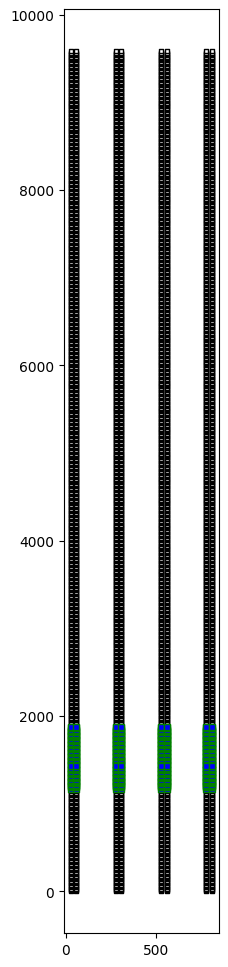

In [3]:
# get the coordinates of the electrodes from the meta file
xc, yc, shanks, kcoords, n_chan = sglx.MetaToCoords(Path(meta_file), outType=0, showPlot=True)
shank_sep = 250
xc = xc + shanks*shank_sep
n_chan = int(n_chan)
chan_map = np.arange(n_chan-1) # exclude last channel which is sync

# This is seemingly no longer a problem with Kilosort4, which can handle multishank probes
# but I'll leave this here for reference in case it's needed in the future.
# if multiple shanks are used, the channel coordinates should be adjusted so that 
# each shank is stacked on top of the previous one. This is necessary for the
# spike sorting to work correctly with Kilosort4, which does not handle multishank 
# probes well.
""" shank_list = np.unique(shanks)
if len(shank_list) > 1:
    offset = 0
    for shank in shank_list:
        idx = np.where(shanks == shank)[0] # get the indices of the channels in the current shank
        y_min = np.min(yc[idx]) # get the minimum y coordinate of the current shank
        yc[idx] = yc[idx] - y_min + offset # adjust the y coordinates of the current shank
        offset = np.max(yc[idx]) + shank_sep # update the offset for the next shank """


probe =  {'chanMap': chan_map, 'xc': xc, 'yc': yc, 'kcoords': kcoords, 'n_chan': n_chan}

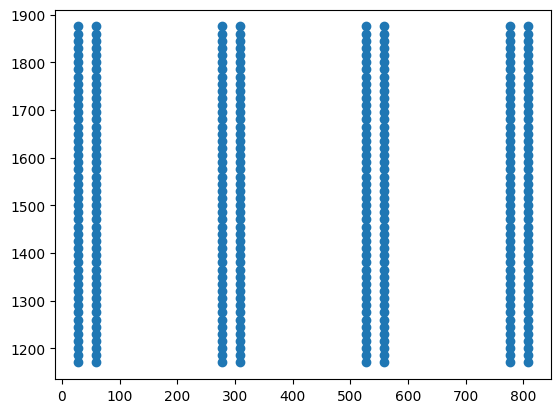

In [4]:
import matplotlib.pyplot as plt
plt.scatter(xc, yc)

In [5]:
probe_file = os.path.join(str(file_dir), 'probe.json')
print('Saving probe file to: {}'.format(probe_file))

save_probe(probe, probe_file)

Saving probe file to: D:\SortingTest\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0\probe.json


### Fix timing, remove common noise, and filter for spikes with CatGT
We use the CatGT function to perform common average referencing (CAR) to clean data intended for spike sorting. Prior to carrying this out, the data must have a correction applied to fix a subtle timing offset. Channels that are multiplexed into the same ADC are sampled at slightly different times, which could cause problems when removing common mode noise that has a fast, large, transients (e.g. electrical stimulation artifacts or head bumps). CatGT corrects for this and then applies CAR. We also apply filtering to isolate unit activity signals.

In [6]:
# test if already ran CatGT
tcat_file = bin_file.replace('_t'+trig_num, '_tcat')

if Path(tcat_file).exists():
    bin_size = Path(bin_file).stat().st_size
    tcat_size = Path(tcat_file).stat().st_size
    tcat_exists = bin_size == tcat_size # only run CatGT if it did not fully run before
else:
    tcat_exists = False

if skip_catgt and tcat_exists:
    print('CatGT already ran, skipping...')
else:
    print('Running CatGT...')
    # file and directory names for CatGT
    catgt_files = '-dir={} -run={} -g={} -t={} -prb={}'.format(
        data_dir, run_name, gate_num, trig_num, probe_num)

    # options for CatGT, can be edited as needed
    catgt_opts = '-ap -prb_fld -gbldmx' # -apfilter=butter,2,300,9000, dropped filter

    # full command for CatGT
    catgt_cmd = 'CatGT {} {}'.format(catgt_files, catgt_opts)

    # run catGT
    cmd_out = subprocess.run(catgt_cmd, shell=True, capture_output=True)
    print(cmd_out.stdout.decode('utf-8'))

CatGT already ran, skipping...


### Run Kilosort4

In [ ]:
# initialize settings with default values
settings = DEFAULT_SETTINGS

# update settings with custom values from config
for key, value in config.items():
    settings[key] = value

# run Kilosort
ops, st, clu, tf, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes \
    = run_kilosort(settings, probe=probe, filename=tcat_file, data_dir=file_dir)

### Bugs

#### Improper data type
Error: 

File c:\Users\dbh60\.conda\envs\kilosort\lib\site-packages\kilosort\run_kilosort.py:398, in detect_spikes(ops, device, bfile, tic0, progress_bar)
    396 tic = time.time()
    397 print(f'\nExtracting spikes using templates')
--> 398 st0, tF, ops = spikedetect.run(ops, bfile, device=device, progress_bar=progress_bar)
    399 tF = torch.from_numpy(tF)
    400 print(f'{len(st0)} spikes extracted in {time.time()-tic : .2f}s; ' + 
...
--> 688     X = (M @ self.whiten_mat) @ X
    689 else:
    690     X = self.whiten_mat @ X

RuntimeError: expected mat1 and mat2 to have the same dtype, but got: double != float

In io,py at line 687 insert `if M.dtype == torch.float64:
                    M = M.float()`



#### Final clustering hangs
Sometimes the final clustering step wont progress. If you find it hangs for several hours then cut down on the number of spikes to sort by increasing the 'Th_learned' parameter in the config dictionary by 1. Keep doing until the step no longer hangs.
